<a href="https://colab.research.google.com/github/dockhs1313/19-lab/blob/master/%ED%8C%80%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
python version: 3.6.8
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit
done
rdkit-2019.09.1 installation finished!


In [0]:
from __future__ import print_function
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [0]:
# General Imports
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
smifile = "gdb11_size08.smi"
data = pd.read_csv('/content/gdb11_size08.smi', delimiter = "\t", names = ["smiles","No","Int"])
from sklearn.model_selection import train_test_split
smiles_train, smiles_test = train_test_split(data["smiles"], random_state=42)
print(smiles_train.shape)
print(smiles_test.shape)

(50029,)
(16677,)


In [0]:
charset = set("".join(list(data.smiles))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
embed = max([len(smile) for smile in data.smiles]) + 5
print(str(charset))
print(len(charset), embed)

{'N', ')', 'c', '-', '=', 'O', '4', 'H', 'n', '[', 'C', '!', '(', '2', 'F', '1', '#', ']', '3', '+', 'o', 'E'}
22 28


N#CC#CC1COC1


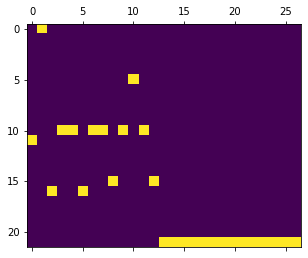

In [0]:
def vectorize(smiles):
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,0:-1,:], one_hot[:,1:,:]
X_train, Y_train = vectorize(smiles_train.values)
X_test,Y_test = vectorize(smiles_test.values)
print(smiles_train.iloc[0])
plt.matshow(X_train[0].T)
#print X_train.shape

In [0]:
"".join([int_to_char[idx] for idx in np.argmax(X_train[0,:,:], axis=1)])

'!N#CC#CC1COC1EEEEEEEEEEEEEE'

In [0]:
try:

    %tensorflow_version 2.x  # %tensorflow_version only exists in Colab

except Exception:

    pass

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x  # %tensorflow_version only exists in Colab`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
#Import Keras objects
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import regularizers
input_shape = X_train.shape[1:]
output_dim = Y_train.shape[-1]
latent_dim = 64
lstm_dim = 64

In [0]:
unroll = False
encoder_inputs = Input(shape=input_shape)
encoder = LSTM(lstm_dim, return_state=True,
                unroll=unroll)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
states = Concatenate(axis=-1)([state_h, state_c])
neck = Dense(latent_dim, activation="relu")
neck_outputs = neck(states)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
decode_h = Dense(lstm_dim, activation="relu")
decode_c = Dense(lstm_dim, activation="relu")
state_h_decoded =  decode_h(neck_outputs)
state_c_decoded =  decode_c(neck_outputs)
encoder_states = [state_h_decoded, state_c_decoded]
decoder_inputs = Input(shape=input_shape)
decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll
                   )
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(output_dim, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
#Define the model, that inputs the training vector for two places, and predicts one character ahead of the input
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 27, 22)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 64), (None,  22272       input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128)          0           lstm[0][1]                       
                                                                 lstm[0][2]                       
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           8256        concatenate[0][0]            

In [0]:
from keras.callbacks import History, ReduceLROnPlateau
h = History()
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, epsilon=1e-5)

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [0]:
from keras.optimizers import RMSprop, Adam #Default 0.001
model.compile( optimizer='Adam', loss='categorical_crossentropy')
model.fit([X_train,X_train],Y_train,
                    epochs=200,
                    batch_size=256,
                    shuffle=True,
                    callbacks=[h, rlr],
                    validation_data=[[X_test,X_test],Y_test ])

Train on 50029 samples, validate on 16677 samples
Epoch 1/200
49920/50029 [============================>.] - ETA: 0s - loss: 0.8404

FailedPreconditionError: ignored